## Интервальные оценки

In [6]:
from functools import partial
from typing import Callable, List, Literal, Optional, Sequence, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sps
import seaborn as sns
from matplotlib.lines import Line2D
from sklearn.datasets import load_wine
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
 
sns.set(style="whitegrid", palette="Set2", font_scale=1.3)
rng = np.random.default_rng(42)

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [7]:
# Создаем данные
X, y = make_classification(n_samples=100, n_features=4, random_state=42)
model = RandomForestClassifier()

# Передаем ВСЕ данные - функция сама разделит их
scores = cross_validate(model, X, y, cv=5)

In [9]:
scores

{'fit_time': array([0.07916427, 0.06209755, 0.06100678, 0.06077242, 0.05442619]),
 'score_time': array([0.00299668, 0.00199795, 0.00299931, 0.00324774, 0.00199723]),
 'test_score': array([0.95, 0.85, 0.9 , 1.  , 1.  ])}

### 1. Интуиция точечных оценок

Ранее мы рассматривали исключительно точечные оценки параметров. Каждому неизвестному параметру сопоставлялось одно число. В задаче регрессии модель возвращала единственное численное значение в качестве предсказания. Однако возникает естественный вопрос: **насколько такие предсказания соответствуют истинному значению?**

Следует помнить, что точечная оценка является случайной величиной — она зависит от конкретной выборки данных и потому не обязана в точности совпадать с истинным параметром. Более того, при изменении данных она может заметно варьироваться.

#### 1.1 Оценки параметров

Для наглядности посмотрим на разброс получаемых оценок относительно истинного значения параметра $\theta$.

In [3]:
def simulate_means(
    theta: float = 0.0, sigma: float = 1.0, sample_size: int = 20, num_replications: int = 5
) -> np.ndarray:
    """
    Симулирует и возвращает выборочные средние из нормального распределения.

    Args:
        theta: Истинное среднее нормального распределения (мат. ожидание).
        sigma: Стандартное отклонение нормального распределения.
        sample_size: Размер каждой генерируемой выборки.
        num_replications: Количество симуляций (сколько выборок сгенерировать).

    Returns:
        Массив, содержащий выборочные средние для каждой симуляции.
    """
    # Генерируем матрицу данных: строки - эксперименты, столбцы - наблюдения
    samples = rng.normal(theta, sigma, size=(num_replications, sample_size))

    # Вычисляем среднее по каждому эксперименту
    return samples.mean(axis=1)


def plot_point_estimates_vs_truth(
    point_estimates: np.ndarray,
    true_parameter: float = 0.0,
    margin: float = 0.2,
    figsize: tuple = (7, 2.2),
) -> None:
    """
    Визуализирует точечные оценки параметра в сравнении с его истинным значением.

    Args:
        point_estimates: Массив точечных оценок, полученных из симуляций.
        true_parameter: Истинное значение параметра, которое мы пытаемся оценить.
        margin: Относительный отступ по краям графика для оси X.
        figsize: Размер фигуры matplotlib (ширина, высота в дюймах).
    """
    point_estimates = np.asarray(point_estimates)
    num_estimates = len(point_estimates)
    y_levels = np.arange(num_estimates)[::-1]

    # Определяем границы для оси X
    min_val = min(point_estimates.min(), true_parameter)
    max_val = max(point_estimates.max(), true_parameter)
    padding = (max_val - min_val) * margin if max_val > min_val else margin
    xlim = (min_val - padding, max_val + padding)

    # График
    fig, ax = plt.subplots(figsize=(figsize[0], figsize[1] + 0.25 * num_estimates))
    ax.set_yticks([])
    ax.set_xlabel("Значения параметра")
    ax.set_xlim(*xlim)

    # Вертикальная линия для истинного значения
    ax.vlines(true_parameter, -1, num_estimates, color="tab:blue", lw=3, alpha=0.8, label="Истина")

    # Отображаем каждую оценку и ее отклонение от истины
    for i, (y_pos, estimate) in enumerate(zip(y_levels, point_estimates)):
        ax.hlines(y_pos, *sorted([estimate, true_parameter]), color="purple", lw=2.5, alpha=0.85)
        ax.plot(estimate, y_pos, "o", color="tab:red", ms=8, label="Оценка" if i == 0 else "")
        ax.plot(true_parameter, y_pos, "o", color="tab:blue", ms=8)

    ax.legend(loc="upper left")
    ax.set_title("Отклонения точечных оценок параметра")
    plt.tight_layout()
    plt.show()

Генерируем 6 выборочных средних из выборок по 20 наблюдений и посмотрим на их отклонения от истины

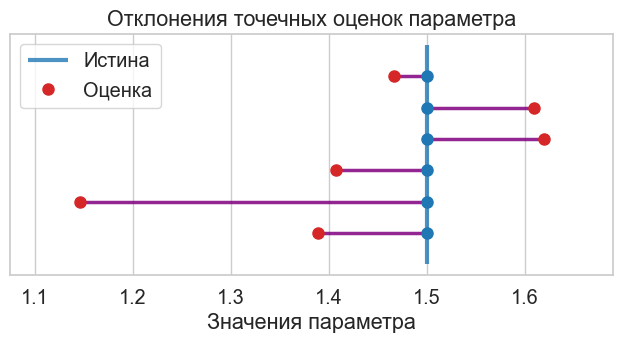

In [4]:
# Истинное значение параметра
theta_true = 1.5

sample_means = simulate_means(theta=theta_true, sigma=1.0, sample_size=20, num_replications=6)

plot_point_estimates_vs_truth(
    point_estimates=sample_means, true_parameter=theta_true, margin=0.15, figsize=(6.5, 2.2)
)

#### 1.2 Отклонения в регрессии

Аналогичная идея применима и в задаче регрессии: модель строит линию регрессии $\widehat{y}(x)$, однако реальные наблюдения $Y_i$ наверняка отклоняются от этого предсказания. Фактически, ни одно наблюдение $Y_i$ не попадает точно на предсказанную линию, что отражает наличие случайной ошибки в данных.

Для наглядности продемонстрируем вертикальные отрезки — «ошибки предсказания» — соединяющие фактические наблюдения $(x_i, Y_i)$ с соответствующими точками на линии регрессии $(x_i, \widehat{y}(x_i))$. Эти отрезки визуализируют величину остатка $e_i = Y_i - \widehat{y}(x_i)$ для каждого наблюдения.

In [5]:
def generate_data(
    num_samples: int = 1000, intercept: float = 2.0, slope: float = 0.6
) -> tuple[np.ndarray, np.ndarray]:
    """
    Генерирует синтетические данные.
    """
    feature_x = np.linspace(0, 10, num_samples)
    error_std = 0.3 + 0.1 * feature_x
    noise = rng.normal(0, error_std, size=num_samples)
    target_y = intercept + slope * feature_x + noise
    return feature_x, target_y


def plot_regression_with_residuals(
    feature: np.ndarray,
    target: np.ndarray,
    xlabel: str = "Признак X",
    ylabel: str = "Таргет Y",
    point_color: str = "tab:red",
    resid_color: str = "purple",
) -> None:
    """
    Строит график линейной регрессии и визуализирует остатки.

    Args:
        feature: Вектор признаков для оси X.
        target: Вектор целевой переменной для оси Y.
        xlabel: Подпись для оси X.
        ylabel: Подпись для оси Y.
        point_color: Цвет точек данных (наблюдений).
        resid_color: Цвет линий, отображающих остатки.
    """
    # Линейная регрессия
    feature = feature.reshape(-1, 1)
    model = LinearRegression().fit(feature, target)
    predicted_values = model.predict(feature)

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.scatter(feature, target, s=36, color=point_color, zorder=3, label="Наблюдения")
    x_line = np.linspace(feature.min(), feature.max(), 300).reshape(-1, 1)
    ax.plot(x_line, model.predict(x_line), color="tab:blue", lw=2.5, label="Линия регрессии")

    # Рисуем остатки
    for x_val, y_val, y_pred in zip(feature, target, predicted_values):
        ax.vlines(x_val, y_val, y_pred, color=resid_color, lw=2, alpha=0.85)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title("Остатки относительно линии регрессии")
    ax.legend()
    plt.tight_layout()
    plt.show()

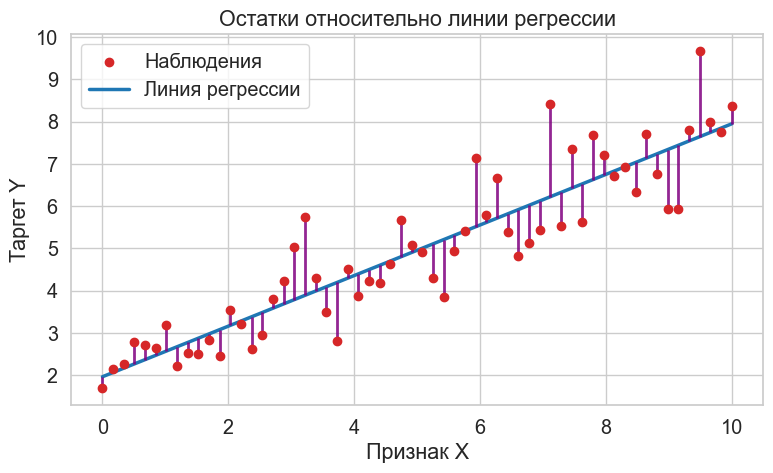

In [6]:
feature, target = generate_data(num_samples=60)
plot_regression_with_residuals(feature, target)

### 1.3. Интуиция по MSE

Мы убедились, что модель регрессии не может точно воспроизвести все наблюдения.  Возникает закономерный вопрос: **как количественно оценить типичную величину ошибки предсказания?** Иными словами, можно ли определить диапазон, в котором с высокой вероятностью находятся реальные значения?

Для оценки ошибки моделей мы ранее использовать **MSE**:
$$
\text{MSE} = \frac{1}{n}\sum_{i=1}^n \left(Y_i - \widehat{Y}_i\right)^2
$$

В качестве первой попытки оценить неопределенность предсказаний можно построить полосу неопределённости вокруг линии регрессии:
$$
\widehat{y}(x) \pm \sqrt{\text{MSE(train)}}
$$

Однако возникает важный вопрос: насколько такая полоса соответствует реальности? Отражает ли она истинную неопределённость и покрывает достаточную долю наблюдений?

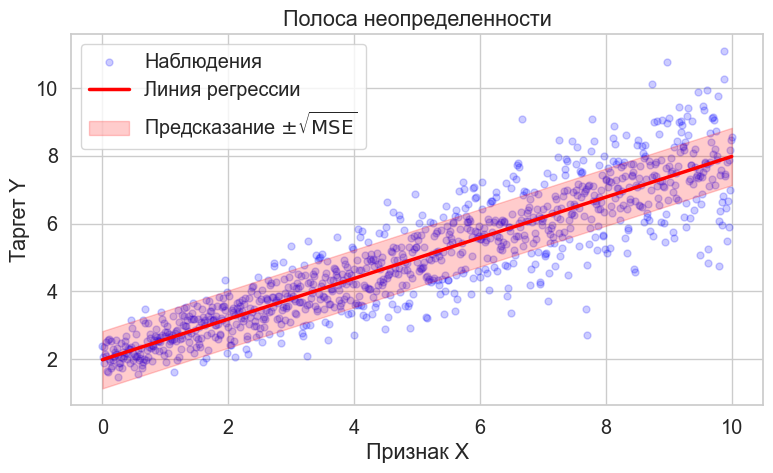

In [7]:
feature, target = generate_data(num_samples=1000)

model = LinearRegression().fit(feature.reshape(-1, 1), target)
predicted = model.predict(feature.reshape(-1, 1))
rmse = np.sqrt(np.mean((target - predicted) ** 2))

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(feature, target, s=25, color="blue", alpha=0.2, label="Наблюдения")
ax.plot(feature, predicted, color="red", lw=2.5, label="Линия регрессии")
ax.fill_between(
    feature,
    predicted - rmse,
    predicted + rmse,
    color="red",
    alpha=0.2,
    label=r"Предсказание $\pm \sqrt{\mathrm{MSE}}$",
)
ax.set_xlabel("Признак X")
ax.set_ylabel("Таргет Y")
ax.set_title("Полоса неопределенности")
ax.legend()
plt.tight_layout()
plt.show()

Полоса $ \widehat{y} \pm \sqrt{\text{MSE(train)}}$ имеет **одинаковую ширину** для всех $x$. Однако на графике точки разбросаны по-разному — разброс увеличивается с ростом $x$. Это означает, что MSE усредняет ошибки и не отражает реальную неопределённость в каждом регионе.  


Чтобы учитывать её корректно, нужны интервалы, зависящие от $x$.



### 2. Доверительные интервалы

Будем сопоставлять точечную оценку с диапазоном значений, который с заданной вероятностью **накрывает** истинный параметр $\theta$.

Так рождается концепция **доверительного интервала**:
$$
\theta \in \bigg(\,\widehat{\theta} - \text{погрешность},\ \widehat{\theta} + \text{погрешность}\,\bigg)
$$

Визуализируем эту идею: покажем единичную оценку $\widehat{\theta}$ с соответствующим доверительным интервалом и отметим истинное значение параметра $\theta$.

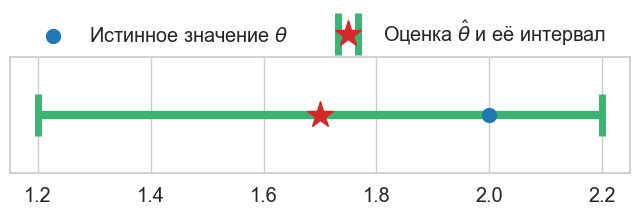

In [8]:
def plot_parameter_interval(
    theta_hat: float, delta: float, theta_true: float = None, figsize: tuple = (8, 1.5)
) -> None:
    """
    Визуализирует точечную оценку, интервал и истинное значение параметра.

    Args:
        theta_true: Истинное значение параметра (синяя точка).
        theta_hat: Точечная оценка параметра (центр интервала).
        delta: Полуширина интервала (расстояние от оценки до края).
        figsize: Размер фигуры matplotlib.
    """
    fig, ax = plt.subplots(figsize=figsize)

    ax.errorbar(
        x=theta_hat,
        y=0,
        xerr=delta,
        fmt="*",
        color="tab:red",
        ecolor="mediumseagreen",
        lw=6,
        markersize=20,
        capsize=15,
        capthick=5,
        label=r"Оценка $\hat{\theta}$ и её интервал",
        zorder=3,
    )

    if theta_true:
        ax.scatter(
            theta_true, 0, s=100, color="tab:blue", label=r"Истинное значение $\theta$", zorder=4
        )

    ax.set_yticks([])
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.5), ncol=2, frameon=False)
    plt.show()


plot_parameter_interval(theta_true=2.0, theta_hat=1.7, delta=0.5)

Интервал построен **вокруг оценки** $\widehat{\theta}$ и накрывает истинное значение $\theta$. При многократном повторении эксперимента, интервалы будут разные. Но примерно в 95 % случаев (для уровня доверия 0.95) они будут **накрывать истинное значение параметра**.  

Это и есть смысл «доверительного уровня» — не вероятность для одной конкретной точки, а свойство процедуры в целом.

Иначе говоря смысл доверительного интервала следующий. **При многократном повторении эксперимента доверительный интервал накрывает истинное значение параметра в 95% случаев.**


Проиллюстрируем это следующим образом:
* сгенерируем большое число выборок из искомого распределения $\mathcal{N}(\theta, \sigma^2)$,
* построим для каждой 95% доверительный интервал $\alpha=0.95$,
* посмотрим, сколько из них пересекает истинное значение параметра.

---

Исследование проведем для точных интервалов в модели $\mathcal{N}(\theta, \sigma^2)$, которые построены на основе распределения Стьюдента. Напишем общую функцию построения этих интервалов, а также для рассмотренных нами на лекции интервалов Вальда. Напомним эти интервалы
 * асимтотический доверительный интервал Вальда
$$\bigg(\overline{X}-\frac{S}{\sqrt{n}}z_{(1+\alpha)/2},\ \overline{X}+\frac{S}{\sqrt{n}}z_{(1+\alpha)/2}\bigg)$$
 * точный неасимптотический доверительный интервал Стьюдента
$$\bigg(\overline{X} - \frac{S}{\sqrt{n-1}}T_{n-1, (1+\alpha)/2},\ \overline{X} + \frac{S}{\sqrt{n-1}}T_{n-1, (1+\alpha)/2}\bigg)$$

Обозначения:
* $\overline{X} = \frac{1}{n}\sum\limits_{i=1}^n X_i$ &mdash; выборочное среднее;
* $S^2 = \frac{1}{n}\sum\limits_{i=1}^n \left( X_i - \overline{X} \right)^2$ &mdash; выборочная дисперсия;
* $z_{\alpha}$ &mdash; $\alpha$-квантиль распределения $\mathcal{N}(0, 1)$;
* $T_{n-1, (1+\alpha)/2}$ &mdash; $\alpha$-квантиль распределения Стюдента $T_{n-1}$.

*Опцию `interval_type='predictive'` в функции разберем далее.*

In [9]:
def calculate_interval(
    data: np.ndarray,
    estimate_type: str = "student",
    interval_type: str = "confidence",
    alpha: float = 0.95,
) -> tuple[float, float, float]:
    """
    Рассчитывает доверительный или предсказательный интервал для среднего.

    Args:
        data: Массив наблюдений (выборка).
            - 1D array: одна выборка.
            - 2D array: множество выборок, где каждая строка - отдельная выборка.
        estimate_type: Способ построения, 'student' (по умолчанию) или 'wald'.
        interval_type: Тип интервала, 'confidence' (по умолчанию) или 'predictive'.
        alpha: Уровень доверия/предсказания (например, 0.95 для 95%).

    Returns:
        Cреднее, нижняя граница интервала, верхняя граница интервала.
    """

    data = np.array(data)

    # Если на входе 1D массив
    is_1d = data.ndim == 1
    if is_1d:
        data = data.reshape(1, -1)

    if data.ndim != 2:
        raise ValueError("Входной массив `data` должен быть 1D или 2D.")

    num_experiments, sample_size = data.shape
    if sample_size < 2:
        raise ValueError("Требуется как минимум 2 наблюдения.")

    ddof = int(estimate_type == "student")  # поправка в случае интервала Стьюдента
    means = np.mean(data, axis=1)  # среднее
    stds = np.std(data, axis=1, ddof=ddof)  # стандартное отклонение, деление на n-ddof
    t_value = sps.t.ppf((1 + alpha) / 2, df=sample_size - 1)  # Квантиль

    # Квантиль
    if estimate_type == "student":
        quantile = sps.t.ppf((1 + alpha) / 2, df=sample_size - 1)
    elif estimate_type == "wald":
        quantile = sps.norm.ppf((1 + alpha) / 2)
    else:
        raise ValueError("Параметр `estimate_type` должен быть 'student' или 'wald'.")

    if interval_type == "confidence":
        margin_of_error = quantile * stds / np.sqrt(sample_size)
    elif interval_type == "predictive":
        margin_of_error = quantile * stds * np.sqrt(1 + 1 / sample_size)
    else:
        raise ValueError("Параметр `interval_type` должен быть 'confidence' или 'predictive'.")

    lower_bounds = means - margin_of_error
    upper_bounds = means + margin_of_error

    if is_1d:
        # Если на входе был 1D массив
        return means[0], lower_bounds[0], upper_bounds[0]
    else:
        return means, lower_bounds, upper_bounds

Для наглядности сгенерируем ровно 100 выборок и посчитаем для каждой из них доверительный интервал

In [16]:
num_experiments = 100
sample_size = 30
alpha = 0.95
true_theta = 0.0  # истинное среднее

# Генерируем все выборки сразу
samples = rng.normal(loc=true_theta, scale=1, size=(num_experiments, sample_size))

# Среднее для каждой выборки
sample_means = samples.mean(axis=-1)

# Доверительные интервалы для каждой выборки
_, lower_bounds, upper_bounds = calculate_interval(samples, alpha=alpha)

Посмотрим, сколько интервалов из 100 смогли покрыть истинное значение параметра

In [17]:
is_covered = (lower_bounds <= true_theta) & (true_theta <= upper_bounds)
is_covered.mean()

np.float64(0.96)

Наконец, визуализируем все эти интервалы

In [18]:
NumericArray = Union[List[float], np.ndarray]


def plot_intervals(
    num_experiments: int,
    lower_bounds: NumericArray,
    upper_bounds: NumericArray,
    sample_means: NumericArray,
    target: Union[float, NumericArray],
    title: str,
) -> None:
    """
    Строит график доверительных или предсказательных интервалов.

    Args:
        num_experiments (int): Общее количество проведенных экспериментов.
        lower_bounds (NumericArray): Нижние границы интервалов для каждого эксперимента.
        upper_bounds (NumericArray): Верхние границы интервалов для каждого эксперимента.
        sample_means (NumericArray): Выборочные средние для каждого эксперимента.
        target (Union[float, NumericArray]): Истинное значение параметра или таргета.
        title (str): Заголовок, который будет отображен на графике.
    """
    # покрытие интервалом цели
    is_covered = (np.array(lower_bounds) <= target) & (target <= np.array(upper_bounds))

    fig, ax = plt.subplots(figsize=(10, 10))
    legend_elements = [
        Line2D([0], [0], color="green", lw=3, label="Интервал покрывает цель"),
        Line2D([0], [0], color="red", lw=3, label="Интервал не покрывает цель"),
        Line2D(
            [0],
            [0],
            marker="o",
            color="k",
            linestyle="None",
            markersize=5,
            label="Выборочное среднее",
        ),
    ]

    # Способы отрисобки таргета
    if isinstance(target, (int, float)):
        # Если параметр один
        ax.axvline(target, color="blue", alpha=0.5, linestyle="--")
        legend_elements.append(
            Line2D(
                [0], [0], color="blue", lw=2, linestyle="--", label=f"Истинное значение = {target}"
            )
        )
    else:
        # Если это массив
        legend_elements.append(
            Line2D(
                [0],
                [0],
                marker="*",
                color="b",
                linestyle="None",
                markersize=7,
                label="Элемент тестовой выборки",
            )
        )

    for i in range(num_experiments):
        y_pos = i + 1
        color = "green" if is_covered[i] else "red"

        # Рисуем интервалы и среднее
        ax.plot([lower_bounds[i], upper_bounds[i]], [y_pos, y_pos], color=color, linewidth=2.3)
        ax.plot(sample_means[i], y_pos, "ko", markersize=3)

        # Если target - массив, рисуем его элементы
        if not isinstance(target, (int, float)):
            ax.plot(target[i], y_pos, "b*", markersize=5)

    # Настройки осей и заголовка
    ax.set_ylim(0, num_experiments + 1)
    ax.set_xlabel(r"Значение параметра $\theta$")
    ax.set_ylabel("Номер эксперимента")
    ax.set_title(title)
    ax.grid(True, axis="x", linestyle="--", alpha=0.3)

    ax.legend(handles=legend_elements, bbox_to_anchor=(1.02, 1), loc="upper left")

    plt.tight_layout()
    plt.show()

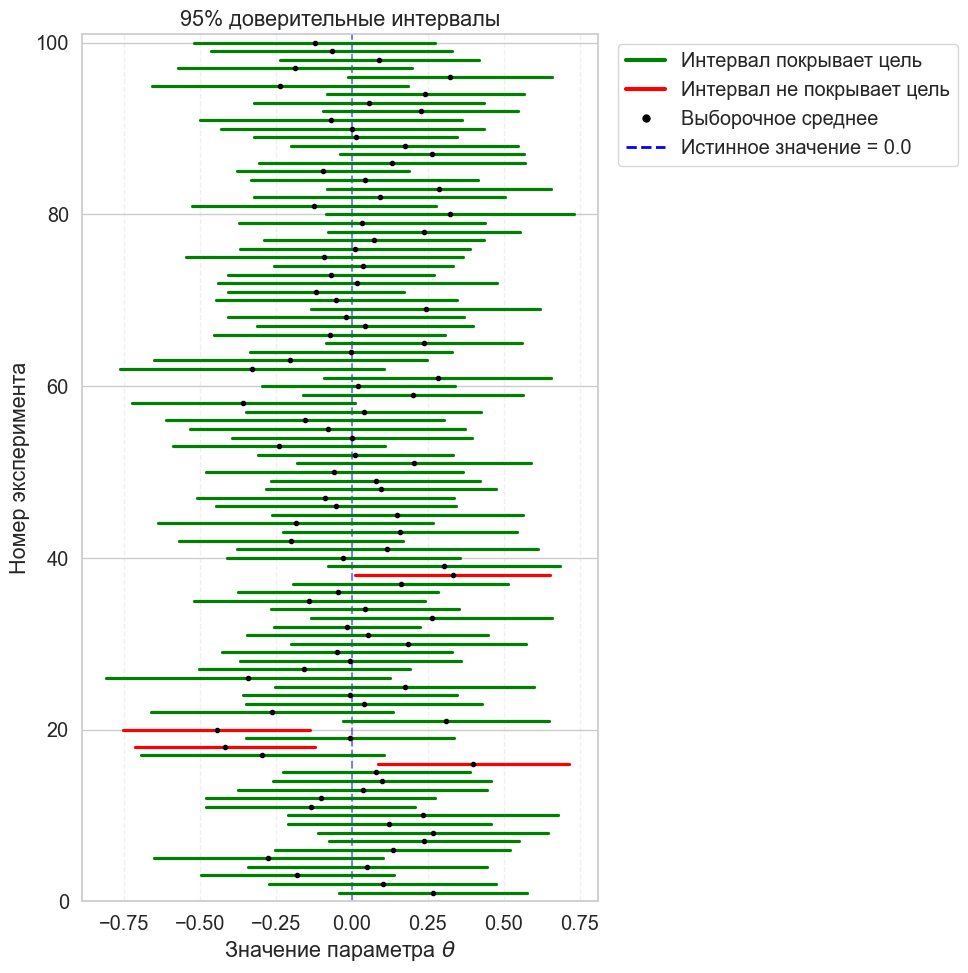

In [19]:
plot_intervals(
    num_experiments=num_experiments,
    lower_bounds=lower_bounds,
    upper_bounds=upper_bounds,
    sample_means=sample_means,
    target=true_theta,
    title=f"{int(alpha*100)}% доверительные интервалы",
)

Доверительный интервал необходимо интерпретировать как случайный объект, который при многократном повторении эксперимента в $\alpha \cdot 100\%$ случаев накрывает истинное значение $\theta$. В одной конкретной реализации истинное значение либо лежит, либо нет.

### 3. Предсказательные интервалы

Ранее мы рассматривали доверительные интервалы для параметров — они характеризуют точность оценки неизвестного, но **фиксированного** параметра. Для таких интервалов мы требовали, чтобы при многократном повторении эксперимента они накрывали истинное значение параметра в заданной доле случаев (например, 95%). Важно еще раз подчеркнуть: параметр является **неслучайной величиной**.

На практике в некоторых задачах возникает необходимость строить интервалы для **будущих наблюдений**. Речь идет не только об оценке среднего значения, но и о прогнозе диапазона, в котором с высокой вероятностью окажется следующее наблюдение. Такие интервалы называются **предсказательными**. Единственное их отличие от доверительных заключается в том, что мы оцениваем **случайную величину** (новое наблюдение), а не фиксированный параметр.

**Примеры**

- *Точечная оценка*: "Путь из дома в аэропорт занимает в среднем 30 минут"
- *Доверительный интервал*: "Среднее время пути составляет от 29 до 31 минуты" — отражает неопределённость в оценке *среднего*
- *Предсказательный интервал*: "Конкретная поездка займёт от 27 до 33 минут" — прогнозирует диапазон для *отдельного наблюдения*. Здесь тем самым мы говорим "скорее всего реальное время поездки будет не меньше 27 минут и не больше 33 минут".

Не лишнее ли это понятие? Можем ли мы использовать обычные доверительные интервалы в качестве предсказательных?

Сгенерируем для предыдущего эксперимента тестовый набор точек &mdash; по одной точке для каждой выборки.

In [20]:
# Тестовые точки для каждой выборки
test_samples = rng.normal(loc=true_theta, scale=1, size=num_experiments)

Посмотрим, сколько интервалов из 100 смогли покрыть эти тестовые точки

In [21]:
is_covered = (lower_bounds <= test_samples) & (test_samples <= upper_bounds)
is_covered.mean()

np.float64(0.2)

Да, здесь все плохо. Давайте посмотрим это на графике

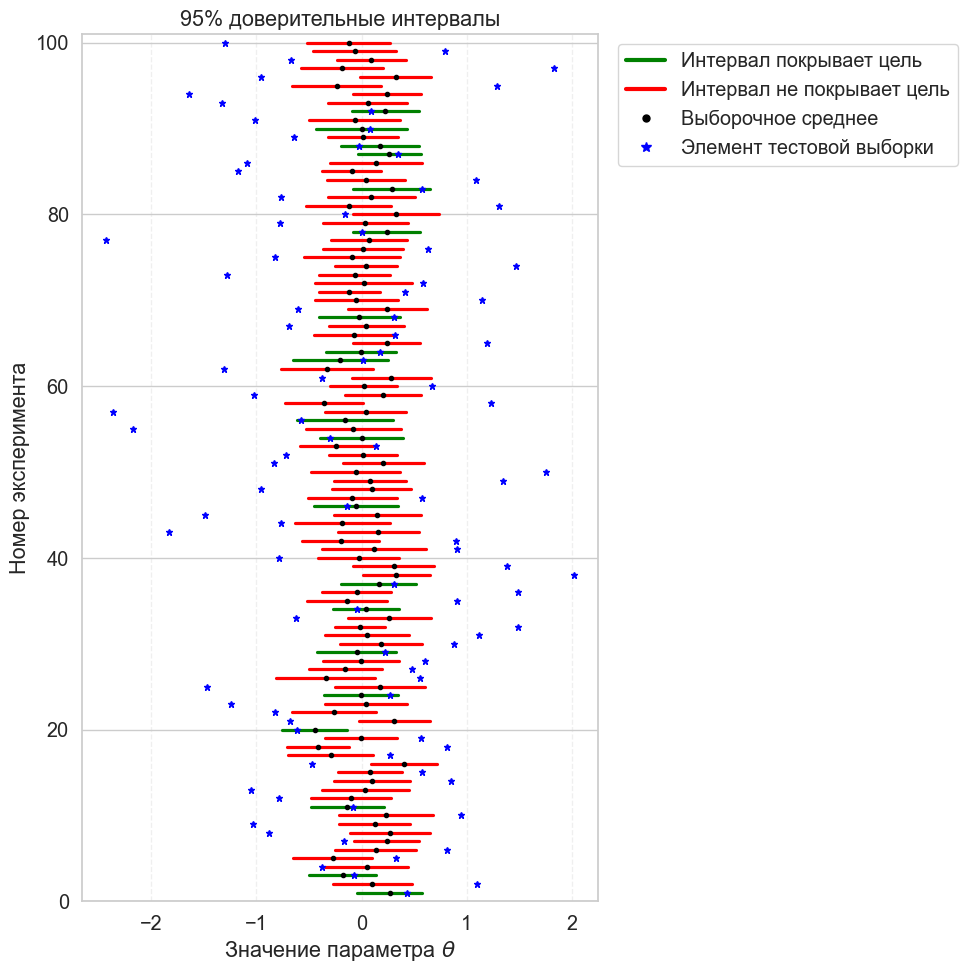

In [22]:
plot_intervals(
    num_experiments=num_experiments,
    lower_bounds=lower_bounds,
    upper_bounds=upper_bounds,
    sample_means=sample_means,
    target=test_samples,
    title=f"{int(alpha*100)}% доверительные интервалы",
)

**Способ построения предсказательных интервалов**

Предположим, что $\theta$ &mdash; параметр сдвига, то есть наблюдения получаются по правилу
$$X_i = \theta + \varepsilon_i,$$
где $\varepsilon_1, ..., \varepsilon_n$ &mdash; независимые одинаково распределенные случайные величины, которые также не зависят от $\theta$.

Тогда если мы оцениваем параметр $\theta$ оценкой $\widehat{\theta}$, то можно ожидать новое наблюдение в виде
$$\widehat{X}_{new} = \widehat{\theta} + \varepsilon_{new}.$$
Поскольку шумы независимы, получаем 
$$\mathsf{D} \widehat{X}_{new} = \mathsf{D}\widehat{\theta} + \mathsf{D}\varepsilon_{new}.$$

Например, если $\mathsf{D}\varepsilon=\sigma^2$ и $\widehat{\theta} = \overline{X}$, то
$$\mathsf{D} \widehat{X}_{new} = \frac{\sigma^2}{n} + \sigma^2 = \sigma^2 \left( \frac{1}{n} + 1 \right).$$

Тем самым в модели $\mathcal{N}(\theta, \sigma^2)$ предсказательные интервалы имеют следующий вид:
* Интервал Вальда
$$\left( \overline{X} \: \pm \: z_{n-1} S \sqrt{\frac{1}{n} + 1} \right)$$
* Интервал Стьюдента
$$\left( \overline{X} \: \pm \: T_{n-1,(1+\alpha)/2} S \sqrt{\frac{1}{n-1} + 1} \right)$$


Предсказательные интервалы всегда шире доверительных, поскольку они учитывают **два источника неопределённости**:
1. Ошибку оценки параметра аналогично доверительным интервалам
2. Индивидуальную случайность нового наблюдения

Это делает предсказательные интервалы полезными на практике, где важно оценивать не только средние тенденции, но и возможный разброс конкретных значений.

---

Построим предсказательные интервалы и посмотрим на их покрытие тестовых семплов

In [24]:
_, lower_bounds, upper_bounds = calculate_interval(samples, interval_type="predictive", alpha=alpha)

is_covered = (lower_bounds <= test_samples) & (test_samples <= upper_bounds)
is_covered.mean()

np.float64(0.96)

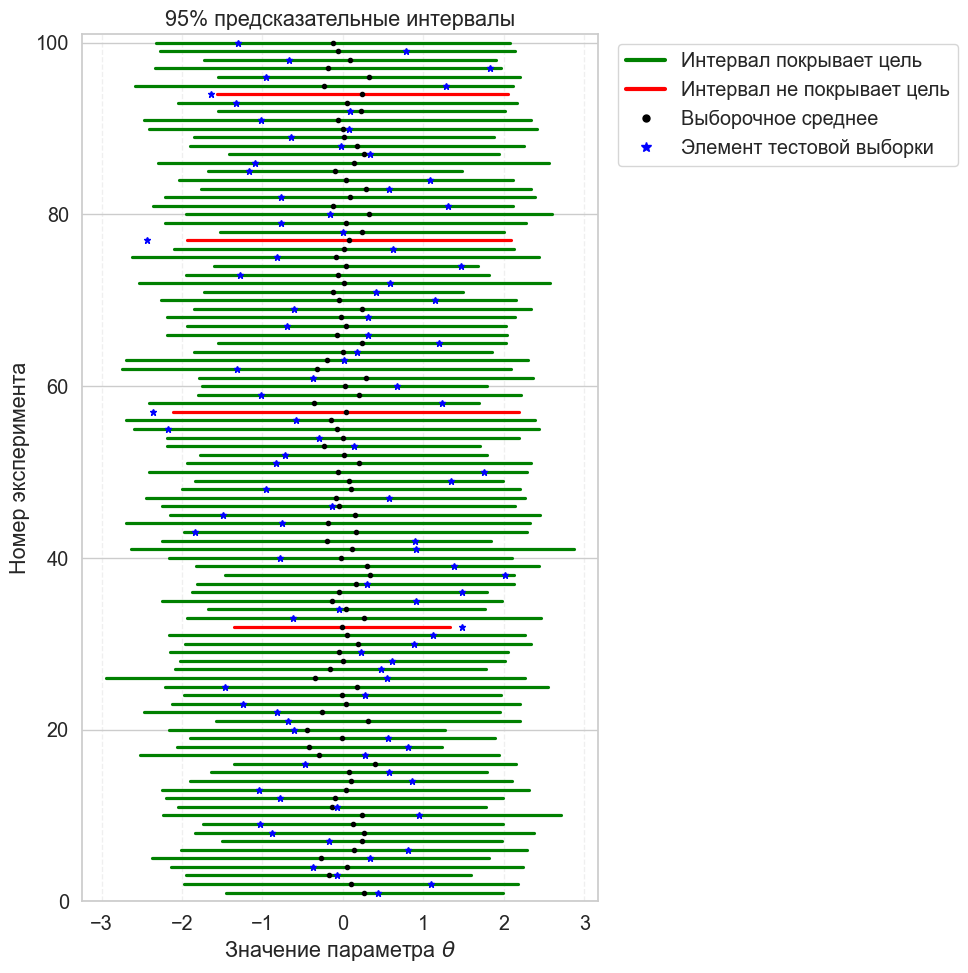

In [25]:
plot_intervals(
    num_experiments=num_experiments,
    lower_bounds=lower_bounds,
    upper_bounds=upper_bounds,
    sample_means=sample_means,
    target=test_samples,
    title=f"{int(alpha*100)}% предсказательные интервалы",
)

На графике мы можем заметить, что интервалы действительно стали шире. Кроме того, они теперь покрывают тестовые точки почти во всех случаях.

### 4. Исследование типов вина

Теперь применим доверительные интервалы на реальных данных. Возьмём **Wine dataset** из библиотеки `sklearn` — классический набор данных для задач классификации и анализа.

Набор данных содержит химический анализ 178 итальянских вин из одного региона трех различных сортов.

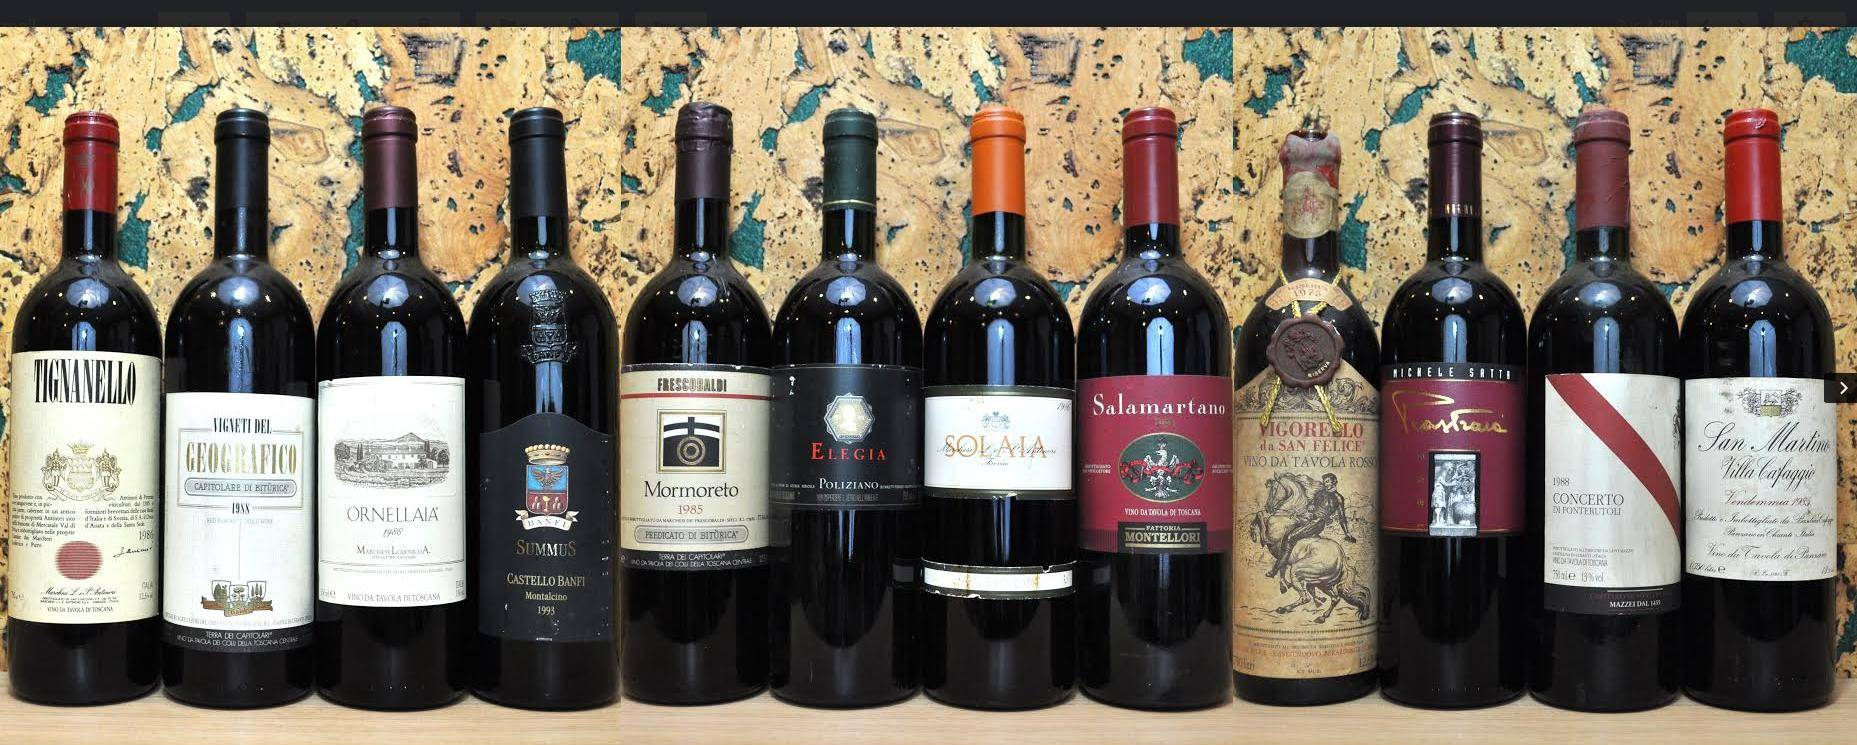

**Признаки:**

* `alcohol` — содержание алкоголя в процентах
* `malic_acid` — содержание яблочной кислоты
* `ash` — содержание золы
* `alcalinity_of_ash` — щёлочность золы
* `magnesium` — содержание магния
* `total_phenols` — общее содержание фенолов
* `flavanoids` — содержание флавоноидов
* `nonflavanoid_phenols` — содержание нефлавоноидных фенолов
* `proanthocyanins` — содержание проантоцианинов
* `color_intensity` — интенсивность цвета
* `hue` — оттенок
* `od280/od315_of_diluted_wines` — оптическая плотность разбавленных вин
* `proline` — содержание пролина

**Таргет:**
* `class` — сорт вина (0, 1, 2)


Загрузим данные и рассмотрим некоторые признаки

In [26]:
data = load_wine(as_frame=True)
df = data.frame.copy()

df.rename(columns={"target": "class"}, inplace=True)
classes = df["class"].unique()
features = ["alcohol", "malic_acid", "color_intensity"]

df.head(5)

alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  class  
0                          3.92   1065.0      0  
1                          3.40   1050.0      0  
2                          3.17   1185.0      0  
3                          3.45   1480.0      0  
4                          2.93    735.0      0

Построим интервалы для среднего значения признаков для каждого класса. 

In [27]:
records = []
for feature in features:
    for c in classes:
        subset = df.loc[df["class"] == c, feature]
        mean, left, right = calculate_interval(subset)
        records.append((feature, c, mean, left, right))

intervals = pd.DataFrame(records, columns=["feature", "class", "mean", "left", "right"])
intervals.head()

feature  class       mean       left      right
0     alcohol      0  13.744746  13.624315  13.865176
1     alcohol      1  12.278732  12.151398  12.406066
2     alcohol      2  13.153750  12.999784  13.307716
3  malic_acid      0   2.010678   1.831241   2.190115
4  malic_acid      1   1.932676   1.692295   2.173057

Нарисуем эти интервалы на графике

In [28]:
def plot_feature_intervals(
    intervals: pd.DataFrame,
    features_to_show: Optional[Sequence[str]] = None,
    colors: Optional[Sequence] = None,
    pad: float = 0.35,
) -> None:
    """
    Визуализирует доверительные интервалы средних признаков по классам.

    Args:
        intervals: DataFrame с колонками ['feature', 'class', 'mean', 'left', 'right'].
        features_to_show: Список признаков для отображения. Если None, покажет первые 5.
        colors: Палитра цветов для классов. Если None, используется палитра Seaborn.
        pad: Вертикальный отступ для интервалов на каждом подграфике.
    """

    if features_to_show is None:
        features_to_show = intervals["feature"].unique()[:5]

    classes = sorted(intervals["class"].unique())
    if colors is None:
        colors = sns.color_palette("Set1", n_colors=len(classes))
    class_to_y_pos = {cls: i for i, cls in enumerate(classes)}
    class_to_color = dict(zip(classes, colors))

    fig, axes = plt.subplots(
        len(features_to_show), 1, figsize=(8, 2 * len(features_to_show)), sharex=False
    )
    if len(features_to_show) == 1:
        axes = [axes]

    for ax, feature_name in zip(axes, features_to_show):
        feature_data = intervals[intervals["feature"] == feature_name]

        for _, row in feature_data.iterrows():
            class_label = row["class"]
            y_pos = class_to_y_pos[class_label]
            с = class_to_color[class_label]

            ax.hlines(y_pos, row["left"], row["right"], color=с, lw=5, alpha=0.8)
            ax.scatter(row["mean"], y_pos, s=80, color=с, zorder=3)

        ax.set_yticks(range(len(classes)))
        ax.set_yticklabels([f"класс {c}" for c in classes])
        ax.set_ylim(-pad, len(classes) - 1 + pad)
        ax.set_title(feature_name)

    plt.tight_layout()
    plt.show()

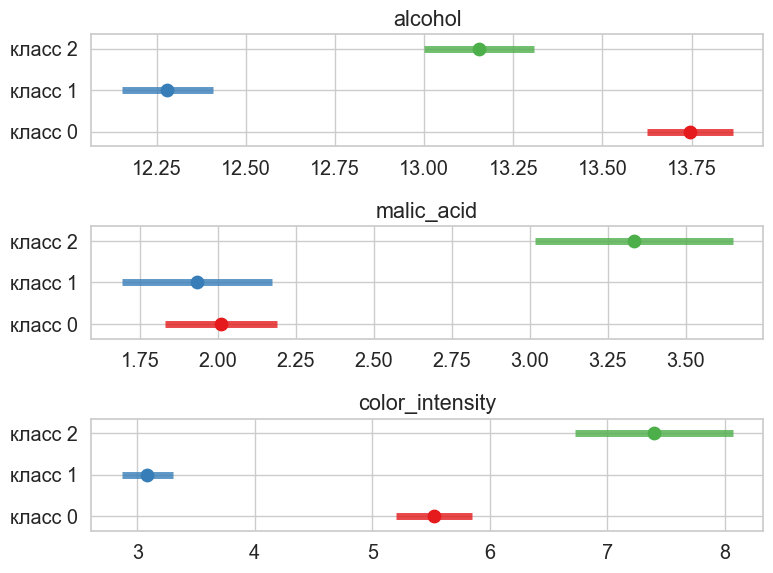

In [29]:
plot_feature_intervals(intervals, features_to_show=features)

По графикам можем сделать следующие выводы
- Для некоторых признаков (например, `alcohol`) интервалы классов почти не пересекаются, значит мы с уверенностью можем сказать, что средние значения этих типов вина отличаются.
- Для других (например, `malic_acid`) интервалы пересекаются сильно. В данном случае мы не можем сказать о том, что вина классов 0 и 1 в среднем отличаются по `malic_acid`.


Теперь посмотрим, как будут выглядеть предсказательные интервалы.

In [30]:
records = []
for feature in features:
    for c in classes:
        subset = df.loc[df["class"] == c, feature]
        mean, left, right = calculate_interval(subset, interval_type="predictive")
        records.append((feature, c, mean, left, right))

intervals = pd.DataFrame(records, columns=["feature", "class", "mean", "left", "right"])
intervals.head()

feature  class       mean       left      right
0     alcohol      0  13.744746  12.811895  14.677597
1     alcohol      1  12.278732  11.198267  13.359198
2     alcohol      2  13.153750  12.075988  14.231512
3  malic_acid      0   2.010678   0.620766   3.400590
4  malic_acid      1   1.932676  -0.107026   3.972378

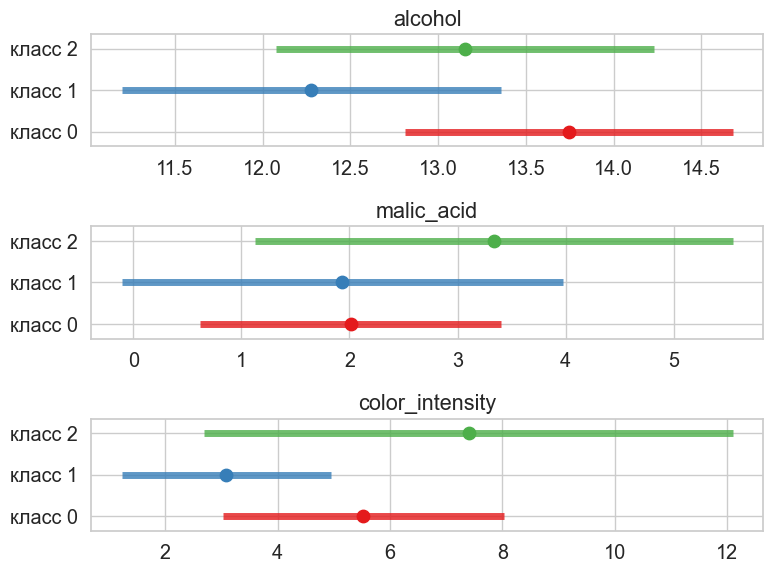

In [31]:
plot_feature_intervals(intervals, features_to_show=features)

По этим графикам видно, что интервалы стали сильно шире, и теперь уже для всех трех типов вина по всем рассмотренным признакам интервалы пересекаются. 

### 5. Сравнение интервалов в зависимости от размера выборки

Проведём сравнение доверительных интервалов Стьюдента и Вальда, исследуя их поведение при различных размерах выборки. 

**Методика эксперимента:**
- Для каждого размера выборки $n$ от 2 до $N$ построим оба типа интервалов
- Визуализируем на графике изменение границ интервалов по мере роста $n$
- Повторим эксперимент многократно и оценим долю покрытия — вероятность, с которой интервал накрывает истинное значение параметра. Этот этап подробнее разберем далее.

Такой подход позволит наглядно увидеть:
- Как интервалы стабилизируются с ростом выборки
- В каких случаях какой из типов интервалов предпочтительнее
- Насколько асимптотически корректен интервал Вальда для больших выборок

---

Напишем функции для построения интервалов для всех $n$ от 2 до $N$ и для визуализации полученного набора интервалов.

In [32]:
ArrayLike = Union[np.ndarray, list]


def calculate_sequential_intervals(
    sample: np.ndarray, interval_calculator: Callable, alpha: float
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Последовательно рассчитывает интервалы для нарастающих срезов выборки.

    Args:
        sample: Входная выборка.
            - 1D array: одна выборка.
            - 2D array: множество выборок, где каждая строка - отдельная выборка.
        interval_calculator: Функция для расчета интервала.
        alpha: Уровень доверия.

    Returns:
        Кортеж из трех массивов: (нижние границы, верхние границы, оценки).
    """
    # Запоминаем, был ли вход 1D
    is_1d = sample.ndim == 1
    data = np.atleast_2d(sample)

    num_experiments, sample_size = data.shape
    lower_bounds = np.full((num_experiments, sample_size), np.nan)
    upper_bounds = np.full((num_experiments, sample_size), np.nan)
    estimates = np.full((num_experiments, sample_size), np.nan)

    # Расчет начинается с выборки размером 2 (индекс i=1)
    for i in range(1, sample_size):
        current_slice = data[:, : i + 1]
        estimate, lower, upper = interval_calculator(current_slice, alpha=alpha)
        lower_bounds[:, i] = lower
        upper_bounds[:, i] = upper
        estimates[:, i] = estimate

    if is_1d:
        # Если на входе был 1D массив
        return lower_bounds.squeeze(), upper_bounds.squeeze(), estimates.squeeze()
    else:
        return lower_bounds, upper_bounds, estimates


def draw_confidence_interval(
    left: ArrayLike,
    right: ArrayLike,
    estimation: Optional[ArrayLike] = None,
    sample: Optional[ArrayLike] = None,
    ylim: Tuple[Optional[float], Optional[float]] = (None, None),
    color_estimation: str = "#FF3300",
    color_interval: str = "#00CC66",
    color_sample: str = "#0066FF",
    label_estimation: Optional[str] = None,
    label_interval: Optional[str] = None,
) -> None:
    """Рисует доверительный интервал и оценку в зависимости от размера выборки.

    Args:
        left (ArrayLike): Массив левых (нижних) границ интервалов.
        right (ArrayLike): Массив правых (верхних) границ интервалов.
        estimation (Optional[ArrayLike]): Массив точечных оценок (по умолчанию None).
        sample (Optional[ArrayLike]): Исходная выборка для отображения (по умолчанию None).
        ylim (tuple, optional): Кортеж для ограничения вертикальной оси (ymin, ymax).
        color_estimation (str): Цвет для линии точечной оценки.
        color_interval (str): Цвет для закрашенной области интервала.
        color_sample (str): Цвет для точек исходной выборки.
        label_estimation (Optional[str]): Текстовая метка для линии оценки в легенде.
        label_interval (Optional[str]): Текстовая метка для области интервала в легенде.
    """

    sample_sizes = np.arange(len(left)) + 1

    assert len(sample_sizes) == len(right)

    if not sample is None:
        plt.scatter(
            sample_sizes,
            sample,
            alpha=0.3,
            color=color_sample,
            s=40,
            label="Элемент выборки",
        )

    if not estimation is None:
        plt.plot(
            sample_sizes,
            estimation,
            color=color_estimation,
            linewidth=2.5,
            label=label_estimation,
        )

    plt.fill_between(
        sample_sizes,
        left,
        right,
        alpha=0.25,
        color=color_interval,
        label=label_interval,
    )
    plt.legend()
    plt.ylim(ylim)
    plt.xlabel("Размер выборки")
    plt.title("Зависимость доверительного интервала от размера выборки")

Построим интервалы для подвыборок размера $n$ от 2 до $N=50$

In [33]:
max_sample_size = 50
sample = np.random.normal(size=max_sample_size)  # выборка
alpha = 0.95  # уровень доверия

left_wald, right_wald, mean = calculate_sequential_intervals(
    sample,
    partial(calculate_interval, estimate_type="wald"),
    alpha=alpha,
)

left_student, right_student, mean = calculate_sequential_intervals(
    sample,
    calculate_interval,
    alpha=alpha,
)

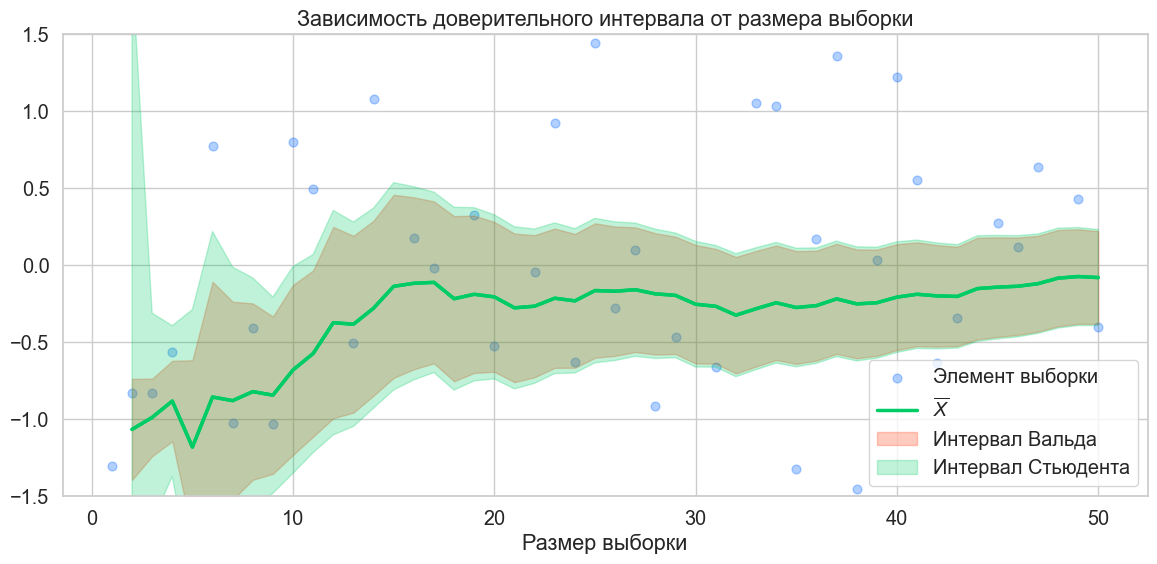

In [37]:
plt.figure(figsize=(14, 6))

draw_confidence_interval(
    left_wald,
    right_wald,
    mean,
    sample,
    ylim=(None, None),
    color_estimation="#00CC66",
    color_interval="#FF3300",
    label_estimation="$\\overline{X}$",
    label_interval="Интервал Вальда",
)

draw_confidence_interval(
    left_student,
    right_student,
    mean,
    ylim=(-1.5, 1.5),
    color_estimation="#00CC66",
    color_interval="#00CC66",
    label_interval="Интервал Стьюдента",
)

Оценим также долю покрытия параметра

In [ ]:
def get_coverage_rate(left, right, theta):
    """
    Вычисляет долю покрытия параметра доверительным интервалом.
    :param left, right: Массивы левых и правых границ доверительных интервалов
    :param theta: Значение параметра
    """

    return np.mean((left <= theta) & (theta <= right), axis=0)

Чтобы с большой надежностью оценить долю покрытия параметра и тем самым сделать надежные выводы при сравнении интервалов Стьюдента и Вальда необходимо провести достаточно большое количество семплирований. 

**Оценка доли покрытия**
- Выполним $10^5$ независимых семплирований
- Для каждого семплирования построим оба типа доверительных интервалов для всех размеров выборок $n$ от 2 до $N$
- По всем семплированиям оценим долю покрытия истинного параметра в зависимости от $n$.

In [ ]:
n_samples = 100_000  # Количество выборок
param_value = 0  # Истинное значение параметра

# Генерируем все выборки
samples = np.random.normal(size=(n_samples, max_sample_size), loc=param_value)

# Считаем интервалы Вальда и оцениваем долю покрытия
left_wald, right_wald, mean = calculate_sequential_intervals(
    samples,
    partial(calculate_interval, estimate_type="wald"),
    alpha=alpha,
)
coverage_rate_wald = get_coverage_rate(left_wald, right_wald, param_value)

# Считаем интервалы Стьюдента и оцениваем долю покрытия
left_student, right_student, mean = calculate_sequential_intervals(
    samples,
    calculate_interval,
    alpha=alpha,
)
coverage_rate_student = get_coverage_rate(left_student, right_student, param_value)

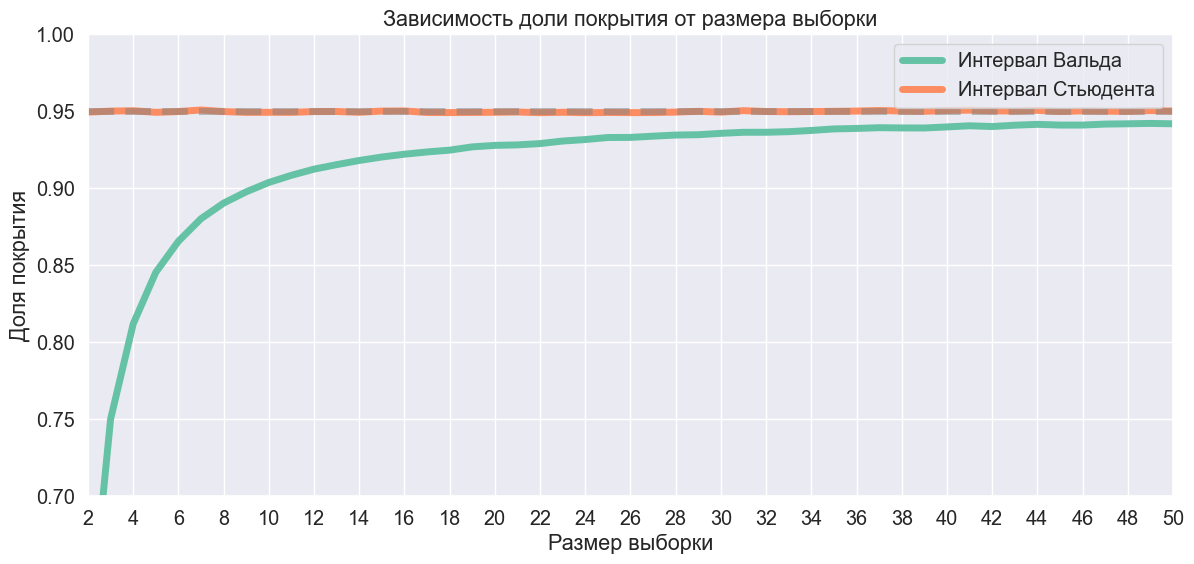

In [40]:
sample_size_grid = np.arange(max_sample_size) + 1

with sns.axes_style("darkgrid"):
    plt.figure(figsize=(14, 6))

    plt.plot(sample_size_grid[1:], coverage_rate_wald[1:], lw=5, label="Интервал Вальда")
    plt.plot(sample_size_grid[1:], coverage_rate_student[1:], lw=5, label="Интервал Стьюдента")
    plt.hlines(alpha, 2, max_sample_size, lw=5, color="gray", linestyles="--", alpha=0.5)
    plt.ylim((0.7, 1.0))
    plt.xlim((2, max_sample_size))
    plt.xticks(np.arange(2, max_sample_size + 1, 2))
    plt.legend()
    plt.xlabel("Размер выборки")
    plt.ylabel("Доля покрытия")
    plt.title("Зависимость доли покрытия от размера выборки")

Мы получили, что при малых размерах выборки интервал Вальда работает плохо. Например, для $n=10$ он покрывает неизвестный истинный параметр лишь в 90% случаев вместо заявленных 95%. Однако с ростом объема данных его качество улучшается.

В отличие от него, интервал Стьюдента является точным и сохраняет корректный уровень доверия при любом размере выборки.

Наконец, сравним доверительный интервал Стьюдента с аналогичным предсказательным интервалом

In [43]:
max_sample_size = 200
sample = np.random.normal(size=max_sample_size)  # выборка
alpha = 0.95  # уровень доверия

left_pred, right_pred, mean = calculate_sequential_intervals(
    sample,
    partial(calculate_interval, interval_type="predictive"),
    alpha=alpha,
)

left_conf, right_conf, mean = calculate_sequential_intervals(
    sample,
    calculate_interval,
    alpha=alpha,
)

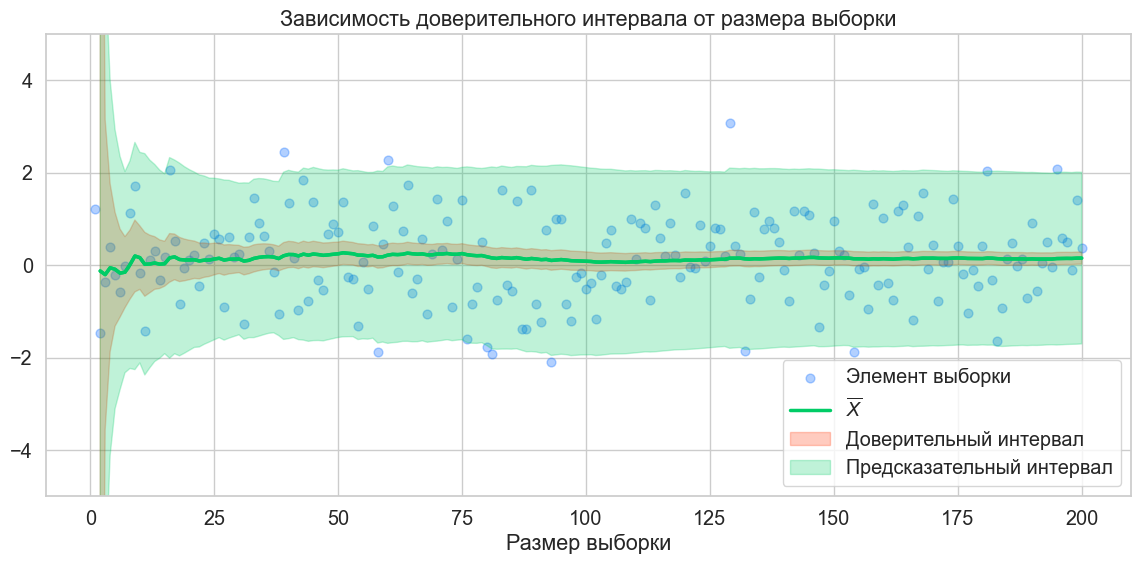

In [44]:
plt.figure(figsize=(14, 6))

draw_confidence_interval(
    left_conf,
    right_conf,
    mean,
    sample,
    ylim=(None, None),
    color_estimation="#00CC66",
    color_interval="#FF3300",
    label_estimation="$\\overline{X}$",
    label_interval="Доверительный интервал",
)

draw_confidence_interval(
    left_pred,
    right_pred,
    mean,
    ylim=(-5, 5),
    color_estimation="#00CC66",
    color_interval="#00CC66",
    label_interval="Предсказательный интервал",
)

Здесь мы видим, что с ростом размера выборки длина доверительного интервала стремится к нулю, отражая всё более точную оценку параметра. В то же время длина предсказательного интервала стабилизируется, приближаясь к естественному разбросу данных, поскольку всегда сохраняется случайная ошибка предсказания.

---
© 2025 команда <a href="https://thetahat.ru/">ThetaHat</a> для курса ML-1 ШАД